<a href="https://colab.research.google.com/github/Rajan-sust/MultiArmedBandit/blob/main/MLBlockChain_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
%%bash

# Up
line=$(grep -n "7:45:42" ml_orderer1.tsv | awk '{print $1}' FS=":")
tail +${line} ml_orderer1.tsv | cut -f 3 | head -n 80 > up.txt
line=$(grep -n "13:57:17" ml_orderer1.tsv | awk '{print $1}' FS=":")
tail +${line} ml_orderer1.tsv | cut -f 3 | head -n 50 >> up.txt

# Down
line=$(grep -n "11:10:52" ml_orderer1.tsv | awk '{print $1}' FS=":")
tail +${line} ml_orderer1.tsv | cut -f 3 | head -n 35 > down.txt

# Stable
line=$(grep -n "8:57:14" ml_orderer1.tsv | awk '{print $1}' FS=":")
tail +${line} ml_orderer1.tsv | cut -f 3 | head -n 100 > stable.txt

In [101]:
def text_file_reader(filename, label):
  with open(filename, mode='r', encoding='utf-8') as file:
    data = file.read().splitlines()
  samples = [float(x) for x in data]
  # print(samples)
  window = 6
  features = []
  for i in range(len(samples) - window + 1):
    ref_idx = i
    feature = [samples[k] - samples[ref_idx] for k in range(ref_idx + 1, ref_idx + window)]
    features.append((feature, label))
  return features


In [102]:
up =  text_file_reader('up.txt', 2)
stable = text_file_reader('stable.txt', 0)
down = text_file_reader('down.txt', 1)

In [103]:
balanced_features = []
mn = min(len(up), len(stable), len(down))

for i in range(mn):
  balanced_features.append(up[i])
  balanced_features.append(stable[i])
  balanced_features.append(down[i])

balanced_features.extend(up[mn:])
balanced_features.extend(stable[mn:])
balanced_features.extend(down[mn:])

In [104]:
import numpy as np

In [ ]:
# !pip install contextualbandits

In [105]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from copy import deepcopy
from contextualbandits.online import ActiveExplorer, AdaptiveGreedy
import numpy as np
import pandas as pd

In [106]:
model = AdaptiveGreedy(base_algorithm=deepcopy(SGDClassifier(random_state=0, loss='log')), nchoices=3,
                       smoothing=(1,2), beta_prior = None, decay_type = 'percentile', decay = 0.9997,
                       batch_train = True, random_state = 4444)

In [ ]:
avg_reward = dict()
cnt = 0
step = 0

for feature, label in balanced_features:
  
  context = np.array([feature])
  # print(context)
  action = model.predict(context)
  # print(action, label)
  reward = (action[0] == label)
  cnt += reward
  step += 1
  avg_reward[step] = (cnt) / (step)
  print(f'iteration no: {step} with reward {avg_reward[step]}')
  model.partial_fit(context, np.array([action]), np.array([[reward]]))

In [108]:
import matplotlib.pyplot as plt

In [109]:
x, fx = [], []
for key, val in avg_reward.items():
  x.append(key)
  fx.append(val)

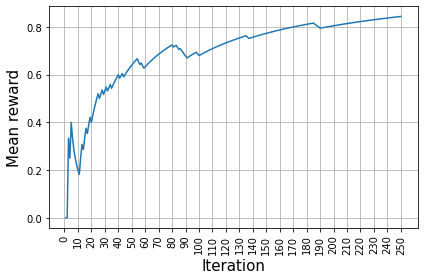

In [111]:
plt.plot(x, fx)
plt.ylabel('Mean reward', fontsize=15)
plt.xlabel('Iteration', fontsize=15)
plt.grid()
plt.xticks(np.arange(0, 251, 10), rotation=90)
# plt.yticks(np.arange(0, , 25))
plt.tight_layout()
plt.savefig('Mean Reward.pdf')